In [1]:
import numpy as np
from scipy.integrate import solve_bvp, solve_ivp
from matplotlib import pyplot as plt

# Create Model

In [2]:
class salt_lake():
    def __init__(self,k1, k2, params, tf,x0):
        """
        This function initializes the parameters for 
        our model
        parameters:
        -----------
        k1 (float): the first constant in the loss 
        function (multiplied by Q)
        k2 (float): the second constant in the loss 
        function (multipled by R)
        params (dict): a dictionary of the parameters used 
        in A and B
        tf (int): final time
        x0 (array): initial state
        """
        
        # Set Q
        self.Q = np.zeros((4,4))
        
        # Set A
        self.A = lambda t: np.array([[0,params['alpha'], -params['beta'], 0],
                        [params['epsilon'], 0, 0, params['lambda'](t)],
                        [params['delta'], 0, 0, 2*params['gamma'](t)],
                         [0,0,0,0]])
        self.A_back = lambda t: np.array([[0,params['alpha'], -params['beta'], 0],
                        [params['epsilon'], 0, 0, params['lambda'](t)],
                        [params['delta'], 0, 0, 2*params['gamma_back'](t)],
                         [0,0,0,0]])

        # Set R 
        self.R = k1
        
        #Set B 
        self.B = np.array([params['row'], 0, 0, 0]).reshape(-1,1)
        
        # Set M
        M = np.zeros((4,4))
        M[0,0] = k2
        self.M = M
        
        # Set x0 and final time
        self.x0 = x0
        self.tf = tf
        
    def find_P(self):
        """
        Find the P used in LQR
        """

        # Define ricatti equation
        def ricatti(t,P):
            P = P.reshape((4,4))
            return (- P@self.A_back(t) - self.A_back(t).T@P - self.Q
                   + P@self.B*1/self.R*self.B.T@P).reshape(16)

        # Find P
        t_span = (self.tf,0)
        t_eval = np.linspace(self.tf, 0, self.tf+1)
        P0 = self.M.flatten()
        sol = solve_ivp(ricatti, t_span, P0, t_eval=t_eval, dense_output=True)

        return sol.sol
    
    def find_state(self):
        """
        Solve for x
        """
        
        # Get P
        P = self.find_P()
        
        # Define ricatti equation
        def func(t,x):
            current_P = P(t).reshape((4,4))
            return self.A_back(t)@x - self.B*1/self.R*self.B.T@current_P@x

        # Find P
        t_span = (0,self.tf)
        t_eval = np.linspace(0, self.tf, self.tf+1)
        x0 = self.x0
        sol = solve_ivp(func, t_span, x0, t_eval=t_eval, dense_output=True)

        return sol.sol
    
    def find_control(self, t_vals):
        
        # Get P and x
        P = self.find_P()
        x = self.find_state()
        
        # Calculate u
        u = np.array([(-1/self.R*self.B.T@(P(t).reshape(4,4))@x(t))[0] for t in t_vals])
        
        return u

# Set parameters

In [3]:
# Set functions
def gamma(t):
    """
    Piece-wise function that averages evaporation per month.
    """
    t = int(t)
    if t%12 == 1:
        return 0
    elif t%12 == 2:
        return 0
    elif t%12 == 3:
        return 2.77/3
    elif t%12 == 4:
        return 5.19/3 - 2.77/3
    elif t%12 == 5:
        return 7.11/3 - 5.19/3
    elif t%12 == 6:
        return 8.8/3 - 7.11/3
    elif t%12 == 7:
        return 9.61/3 - 8.8/3
    elif t%12 == 8:
        return 8.58/3 - 9.61/3
    elif t%12 == 9:
        return 6.1/3 - 8.58/3
    elif t%12 == 10:
        return 3.81/3 - 6.1/3
    elif t%12 == 11:
        return 1.42 - 3.81/3
    elif t%12 == 0:
        return 0 - 1.42
    
def gamma_back(t):
    """
    Piece-wise function that averages evaporation per month.
    """
    t = int(t)
    if t%12 == 1:
        return 0
    elif t%12 == 2:
        return -2.77/3
    elif t%12 == 3:
        return 2.77/3 - 5.19/3
    elif t%12 == 4:
        return 5.19/3 - 7.11/3
    elif t%12 == 5:
        return 7.11/3 - 8.8/3
    elif t%12 == 6:
        return 8.8/3 - 9.61/3
    elif t%12 == 7:
        return 9.61/3 - 8.58/3
    elif t%12 == 8:
        return 8.58/3 - 6.1/3
    elif t%12 == 9:
        return 6.1/3 - 3.81/3
    elif t%12 == 10:
        return 3.81/3 - 1.42
    elif t%12 == 11:
        return 1.42
    elif t%12 == 0:
        return 0
    
def lambda_(t):
    t = int(t)
    if t%12 == 1:
        return 0.1 #4.4
    elif t%12 == 2:
        return -1 #3.4
    elif t%12 == 3:
        return -1.2 #2.2
    elif t%12 == 4:
        return -0.3 #1.9
    elif t%12 == 5:
        return -0.2 #1.7
    elif t%12 == 6:
        return -0.8 #0.9
    elif t%12 == 7:
        return -0.4 #0.5
    elif t%12 == 8:
        return 0.2 #0.7
    elif t%12 == 9:
        return 0.5 #1.2
    elif t%12 == 10:
        return 0.3 #1.5
    elif t%12 == 11:
        return 0.9 #2.4
    elif t%12 == 0:
        return 1.9 #4.3

# Set parameters
alpha = 1
beta = 1 #change in depth = alpha*rainfall + beta*evaporation
epsilon = 0 #rainfall = epsilon*change in depth + lambda(t)
delta = 0 #evaporation = delta*change in depth + gamma(t)
row = .98
tf = 60
k1 = 1
k2 = 1

# Set x0
x0 = np.array([-128, 2.4, 3.81/3, 1])

# Create parameter dict
params = {'alpha': alpha, 'beta':beta, 'epsilon':epsilon,
         'delta': delta, 'row':row, 'gamma':gamma, 
         'gamma_back':gamma_back,'lambda': lambda_}

# Solve for state and control

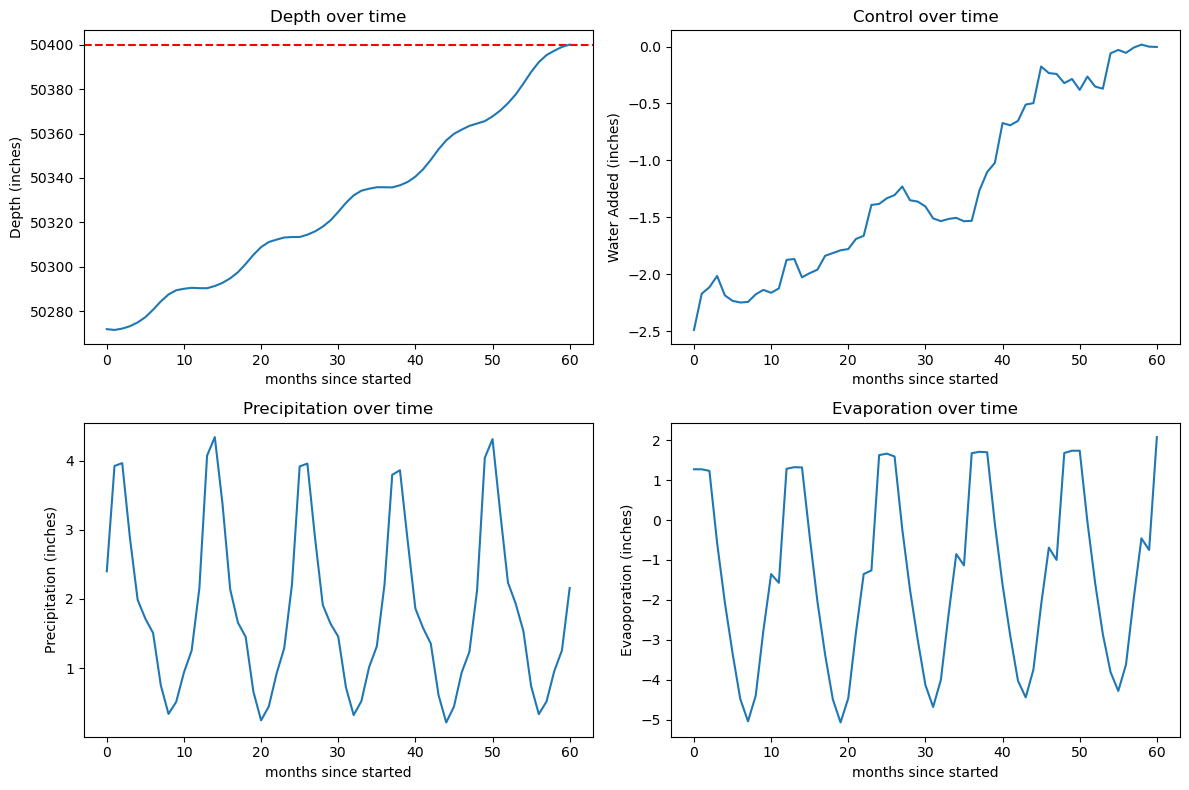

In [5]:
# Find state and control
sl = salt_lake(k1,k2,params,tf,x0)
x = sl.find_state()
t_vals = np.linspace(0, tf, tf+1)
x_vals = x(t_vals)
u = sl.find_control(t_vals)

# Plot depth
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.axhline(y = 50400, color = 'r', linestyle = '--')
# plt.plot(t_vals, x_vals[0])
plt.plot(t_vals, x_vals[0]+50400)
plt.xlabel('months since started')
# plt.ylabel('Difference in depth (inches)')
plt.ylabel('Depth (inches)')
# plt.title('Depth difference over time')
plt.title('Depth over time')

# Plot control
plt.subplot(2,2,2)
plt.plot(t_vals, u)
plt.xlabel('months since started')
plt.ylabel('Water Added (inches)')
plt.title('Control over time')

# Plot precipitation
plt.subplot(2,2,3)
plt.plot(t_vals, x_vals[1])
plt.xlabel('months since started')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation over time')

# Plot evaporation
plt.subplot(2,2,4)
plt.plot(t_vals, x_vals[2])
plt.xlabel('months since started')
plt.ylabel('Evaoporation (inches)')
plt.title('Evaporation over time')
plt.tight_layout()
plt.show()

# Try Many Parameters

In [6]:
# plt.figure(figsize=(12,12))
# for alpha in [0.01,0.03,0.05,0.07,0.1,0.4,0.7,1]:
# for tf in [36,60,84,120]:
plt.figure(figsize=(12,12))
for k1 in [0.2,0.6,1]:
        for k2 in [0.2,0.6,1]:
                # Set parameters
                alpha = 1
                beta = 1 #change in depth = alpha*rainfall + beta*evaporation
                epsilon = 0 #rainfall = epsilon*change in depth + lambda(t)
                delta = 0 #evaporation = delta*change in depth + gamma(t)
                row = .98
                tf = 60

                # Set x0
                x0 = np.array([-128, 4.4, 0, 1])

                # Create parameter dict
                params = {'alpha': alpha, 'beta':beta, 'epsilon':epsilon,
                        'delta': delta, 'row':row, 'gamma':gamma, 
                        'lambda': lambda_}

                # Find state and control
                sl = salt_lake(k1,k2,params,tf,x0)
                x = sl.find_state()
                t_vals = np.linspace(0, tf, tf+1)
                x_vals = x(t_vals)
                u = sl.find_control(t_vals)

                # Plot depth
                plt.subplot(2,2,1)
                plt.axhline(y = 50400, color = 'r', linestyle = '--')
                # plt.plot(t_vals, x_vals[0], label=f'{k1},{k2}')
                plt.plot(t_vals, x_vals[0]+50400, label=f'{k1},{k2}')
                plt.xlabel('months since started')
                plt.ylabel('Depth (inches)')
                # plt.ylabel('Difference in depth (inches)')
                # plt.title('Depth difference over time')
                plt.title('Depth over time')

                # Plot control
                plt.subplot(2,2,2)
                plt.plot(t_vals, u, label=f'{k1},{k2}')
                plt.xlabel('months since started')
                plt.ylabel('Water Added (inches)')
                plt.title('Control over time')
plt.legend(loc=(1.04, 0), title='k1,k2')
plt.suptitle('Optimal Control with k1 (cost of adding water) and k2 (cost of endpoint depth) parameters')
plt.tight_layout()
plt.show()

            # # Plot precipitation
            # plt.subplot(2,2,3)
            # plt.plot(t_vals, x_vals[1])
            # plt.xlabel('months since started')
            # plt.ylabel('Precipitation')
            # plt.title('Precipitation over time')

            # # Plot evaporation
            # plt.subplot(2,2,4)
            # plt.plot(t_vals, x_vals[2])
            # plt.xlabel('months since started')
            # plt.ylabel('Evaoporation')
            # plt.title('Evaporation over time')
            # plt.tight_layout()
            # plt.show()

KeyError: 'gamma_back'

<Figure size 1200x1200 with 0 Axes>